**Graph Contrastive Learning with Augmentations (GraphCL)**
- https://proceedings.neurips.cc/paper_files/paper/2020/hash/3fe230348e9a12c13120749e3f9fa4cd-Abstract.html
- Performing contrastive learning on graph data using graph augmentations

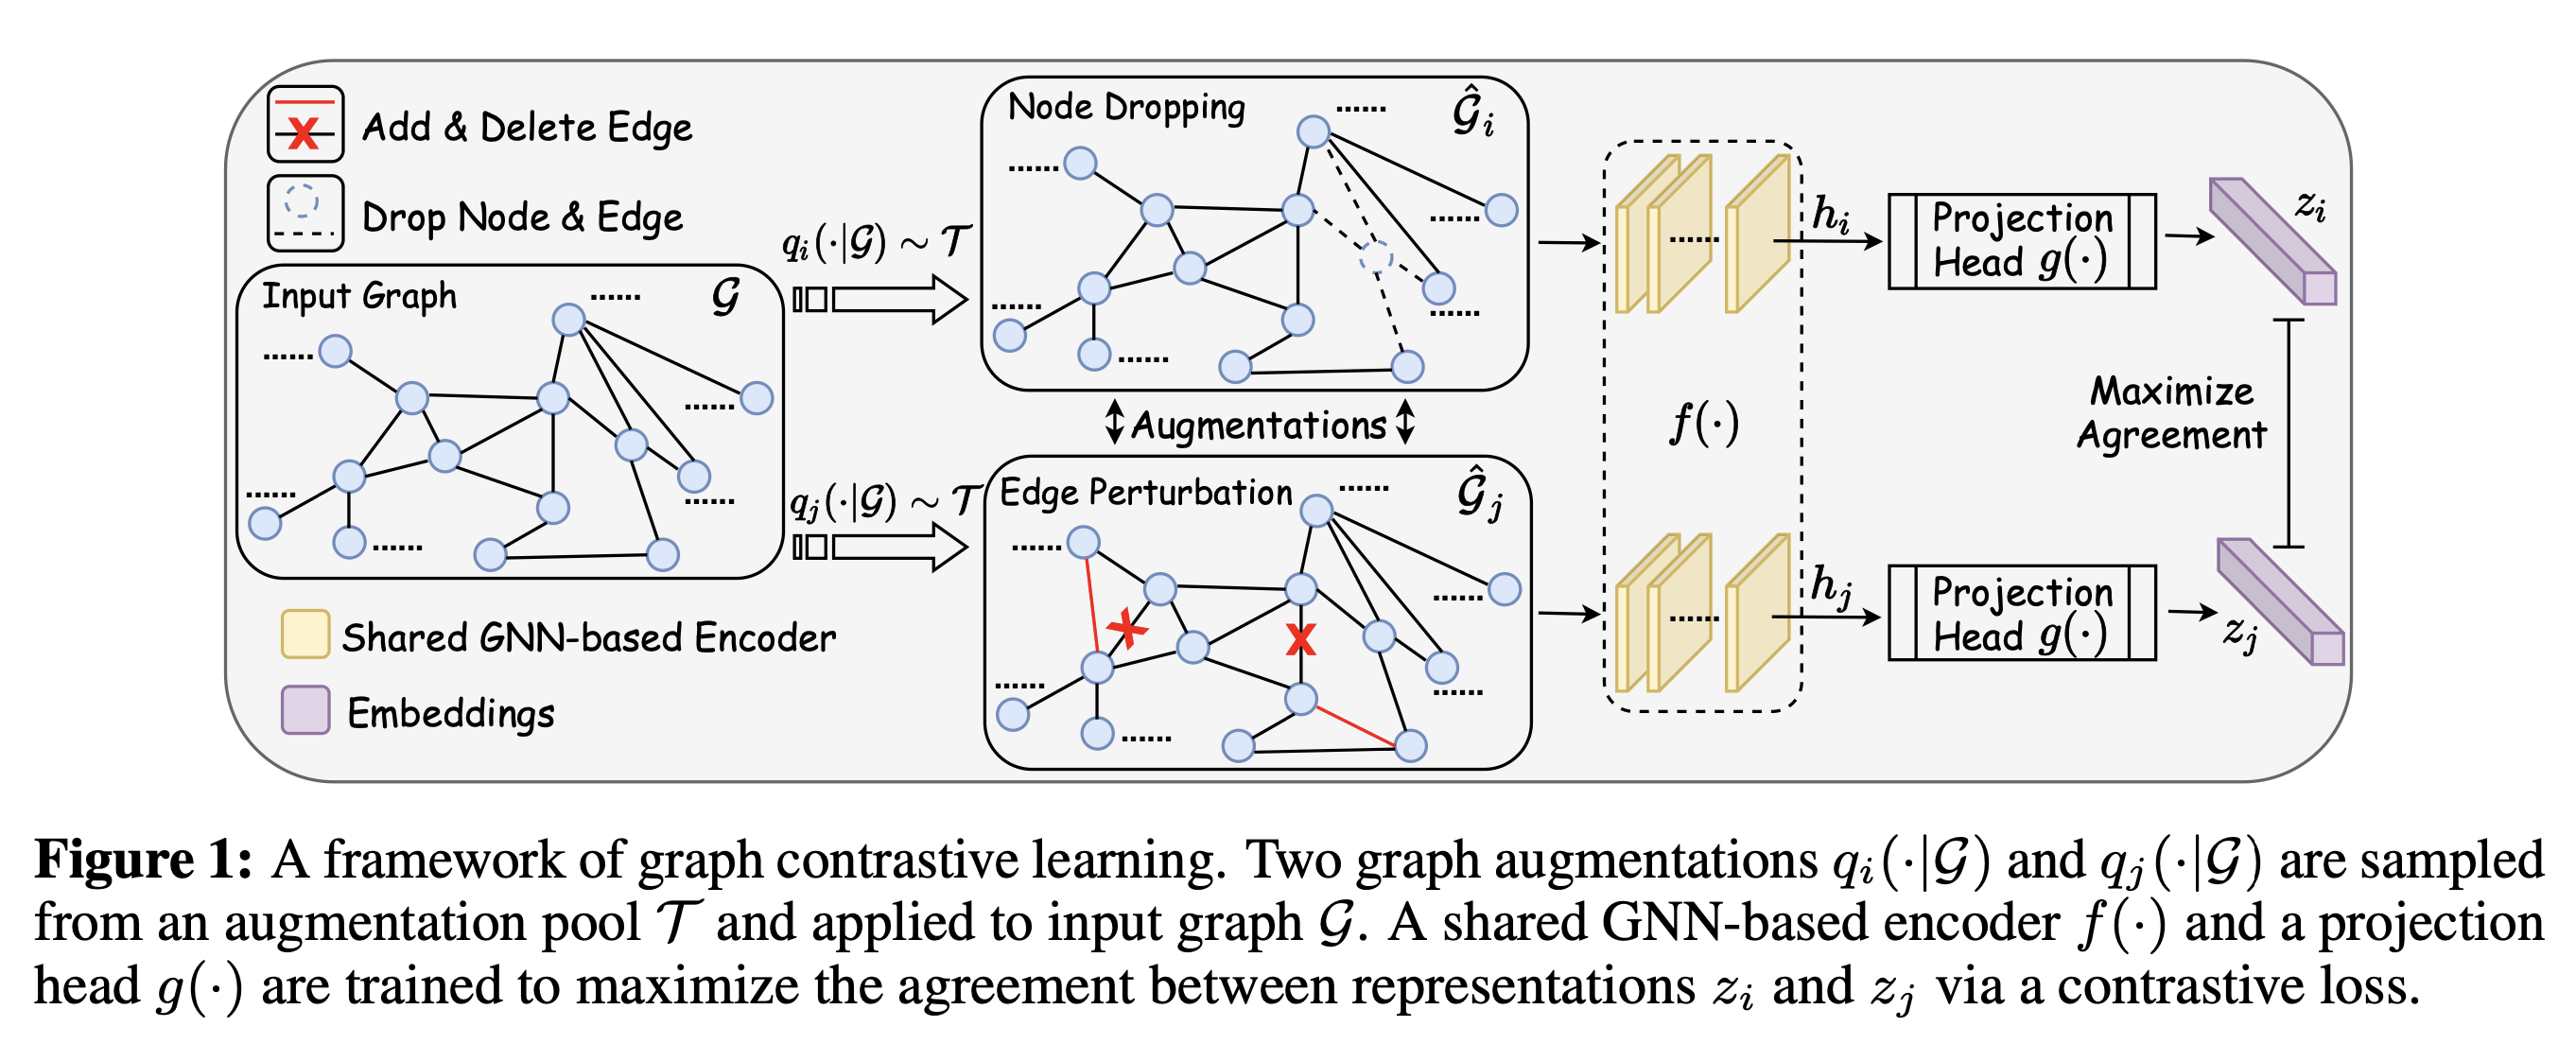

Reference of this notebook: https://github.com/PyGCL/PyGCL/blob/main/examples/GraphCL.py

**Start GPU mode first**

**Setup environment**

In [ ]:
!pip3 install torch==2.4.0 --index-url https://download.pytorch.org/whl/cu121
!pip install dgl -f https://data.dgl.ai/wheels/torch-2.4/cu121/repo.html
!pip install PyGCL
!pip install torch-scatter torch-sparse torch-cluster torch-geometric -f https://data.pyg.org/whl/torch-2.4.0+cu121.html

Looking in indexes: https://download.pytorch.org/whl/cu121
Looking in links: https://data.dgl.ai/wheels/torch-2.4/cu121/repo.html
Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 43.0 MB/s eta 0:00:00


**Import libriaries**

In [ ]:
import torch
import os.path as osp
import GCL.losses as L
import GCL.augmentors as A
import torch.nn.functional as F

from torch import nn
from tqdm import tqdm
from torch.optim import Adam
from GCL.eval import get_split, SVMEvaluator
from GCL.models import DualBranchContrast
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.data import DataLoader
from torch_geometric.datasets import TUDataset

**Construct GNN model**

In [ ]:
def make_gin_conv(input_dim, out_dim):
    return GINConv(nn.Sequential(nn.Linear(input_dim, out_dim), nn.ReLU(), nn.Linear(out_dim, out_dim)))


class GConv(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(GConv, self).__init__()
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        for i in range(num_layers):
            if i == 0:
                self.layers.append(make_gin_conv(input_dim, hidden_dim))
            else:
                self.layers.append(make_gin_conv(hidden_dim, hidden_dim))
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))

        project_dim = hidden_dim * num_layers
        self.project = ?
        # ToDo: Create a 2-layer MLP projector, I/O dimensions are project_dim

    def forward(self, x, edge_index, batch):
        z = x
        zs = []
        for conv, bn in zip(self.layers, self.batch_norms):
            z = conv(z, edge_index)
            z = F.relu(z)
            z = bn(z)
            zs.append(z)
        gs = [global_add_pool(z, batch) for z in zs]
        z, g = [torch.cat(x, dim=1) for x in [zs, gs]]
        return z, g

Question: will changing the projector depth affect the final performance?

**Construct graph aumentation and encoding pipeline**

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self, encoder, augmentor):
        super(Encoder, self).__init__()
        self.encoder = encoder
        self.augmentor = augmentor

    def forward(self, x, edge_index, batch):
        aug1, aug2 = self.augmentor
        x1, edge_index1, edge_weight1 = aug1(x, edge_index)
        x2, edge_index2, edge_weight2 = aug2(x, edge_index)
        z, g = self.encoder(x, edge_index, batch)
        z1, g1 = self.encoder(x1, edge_index1, batch)
        z2, g2 = self.encoder(x2, edge_index2, batch)
        return z, g, z1, z2, g1, g2

**Construct contrastive training and test pipelines**

In [ ]:
def train(encoder_model, contrast_model, dataloader, optimizer):
    encoder_model.train()
    epoch_loss = 0
    for data in dataloader:
        data = data.to('cuda')
        optimizer.zero_grad()

        if data.x is None:
            num_nodes = data.batch.size(0)
            data.x = torch.ones((num_nodes, 1), dtype=torch.float32, device=data.batch.device)

        _, _, _, _, g1, g2 = encoder_model(data.x, data.edge_index, data.batch)
        g1, g2 = [encoder_model.encoder.project(g) for g in [g1, g2]]
        loss = contrast_model(g1=g1, g2=g2, batch=data.batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    return epoch_loss

def test(encoder_model, dataloader):
    encoder_model.eval()
    x = []
    y = []
    for data in dataloader:
        data = data.to('cuda')
        if data.x is None:
            num_nodes = data.batch.size(0)
            data.x = torch.ones((num_nodes, 1), dtype=torch.float32, device=data.batch.device)
        _, g, _, _, _, _ = encoder_model(data.x, data.edge_index, data.batch)
        x.append(g)
        y.append(data.y)
    x = torch.cat(x, dim=0)
    y = torch.cat(y, dim=0)

    split = get_split(num_samples=x.size()[0], train_ratio=0.8, test_ratio=0.1)
    result = SVMEvaluator(linear=True)(x, y, split)
    return result

**Load MUTAG dataset** (Structure-activity relationship of mutagenic aromatic and heteroaromatic nitro compounds. Correlation with molecular orbital energies and hydrophobicity)

More datasets can be found here: https://chrsmrrs.github.io/datasets/docs/datasets/

In [ ]:
device = torch.device('cuda')
path = osp.join(osp.expanduser('~'), 'datasets')
dataset = TUDataset(path, name='NCI1')
dataloader = DataLoader(dataset, batch_size=128)
input_dim = max(dataset.num_features, 1)

Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Question: Can you also try other datasets?

**Define graph augmentation functions**

In [ ]:
aug1 = A.NodeDropping(pn=0.2)
aug2 = A.NodeDropping(pn=0.2)

Question: Can you also try other augmentations?

**Build models and optimizers**

In [ ]:
gconv = GConv(input_dim=input_dim, hidden_dim=32, num_layers=2).to(device)
encoder_model = Encoder(encoder=gconv, augmentor=(aug1, aug2)).to(device)
contrast_model = DualBranchContrast(loss=L.InfoNCE(tau=0.2), mode='G2G').to(device)

optimizer = Adam(encoder_model.parameters(), lr=0.01)

**Test randomly initialized models**

In [ ]:
test_result = test(encoder_model, dataloader)
print(f'(E): Best test F1Mi={test_result["micro_f1"]:.4f}, F1Ma={test_result["macro_f1"]:.4f}')

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


(E): Best test F1Mi=0.6983, F1Ma=0.6973


Question: Why is this evaluation important?

**Train GraphCL**

In [ ]:
with tqdm(total=100, desc='(T)') as pbar:
  for epoch in range(1, 101):
      loss = train(encoder_model, contrast_model, dataloader, optimizer)
      pbar.set_postfix({'loss': loss})
      pbar.update()

(T): 100%|██████████| 100/100 [01:05<00:00,  1.52it/s, loss=38.6]


**Test GraphCL**

In [ ]:
test_result = test(encoder_model, dataloader)
print(f'(E): Best test F1Mi={test_result["micro_f1"]:.4f}, F1Ma={test_result["macro_f1"]:.4f}')

(E): Best test F1Mi=0.7470, F1Ma=0.7469
